# **Gauss-Seidel Method**

As discussed in the Introduction and problem identification section, we needed an implementation for the Gauss-Seidel method to solve the linear equations of the Cubic Spline. Before Implementation I needed to disscuss the algorithm and why we choose Gauss-Seidel method. As we saw in the Introduction the matrix is diagonally dominant which can be easily implemented by Gauss's method, but why not by elimination or any other method? The answer for this is that for any other method such as elimination for a high set of equations it will be prone to round-off errors and since we already have a diagonally dominant matrix we can easily rewrite the set of equations for each variable as function of the other variables. As an example for this consider this system,

$c_{11}x_{1} + c_{12}x_{2} +…+c_{1n}x_{n} = a_{1}$

$c_{21}x_{1} + c_{22}x_{2} +…+c_{2n}x_{n} = a_{2}$

$\vdots$

$c_{n1}x_{1} + c_{n2}x_{2} +\dots +c_{nn}x_{n} = a_{n}$

Since the matrix is diagonally dominant we can rewrite the equations as:

$x_{1} = \frac{a_{1} - c_{12}x_{2} - …+c_{1n}x_{n}}{c_{11}} $

$\vdots$

$x_{n} = \frac{a_{1} - c_{n2}x_{2} - …+c_{n(n-1)}x_{n}}{c_{nn}} $

for the implementation simplicity we generalize it to,

$x_{i}=\sum_{i=1}^{n} \frac{c_{ij} - \sum_{j = 1,j!=i}^{n}c_{ij}x_{j}}{a_{ii}}$


In [ ]:
def solve(a, c, eps=1e-6, it=100):#it for num of iterations, eps for epsilon could've edited it to the machine epsilon.
    n = len(a) #num of equations
    cur = [0] * n #temporary array used for each iteration in it
    soln = [0] * n #obviously the answer, it will be the initial value for the next iteration.
    for q in range(it):
        for i in range(n):
            s = sum(soln[j]*a[i][j] for j in range(n) if(j!=i))#applying the generalized formula we deduced above
            cur[i] = (c[i] - s) / a[i][i]
        if all(abs(cur[i] - soln[i]) < eps for i in range(n)): # the check for the error or epsilon by taking the difference of the prev value and the current one
            return cur
        soln = cur.copy() # taking a copy to check for the case where the difference is less than the epsilon.
    return None #else there is no soln for this system

In [ ]:
# test input for this system
test = [[2, 1], [3, 4]]
f = [3, 6]

print(solve(test, f))


[1.2000001223461396, 0.6000003670384189]


# **Natural Cubic Spline**

In this part we will implement the natural cubic spline using Gauss-Seidel method to solve the system that we introduced in the introduction part for the natural cubic spline, a small note here is that I don't prefer using numpy or any library just implementing stuff from scratch is what makes me feel like a human.For now as we saw earlier we needed to solve the system for the c's after that we would compute b's, d's and a's are already the initial step of the interpolation with that being said the implementation is down below with it's comments explaining it clearly.

In [ ]:
def natural_spl(x, y, value):
    n = len(x) # num of data points
    a = y[0:len(y)] #initials
    b = [0]*n; d = [0]*n #initializing b's and d's instead of using them dynamic
    rhs = [0]*n # the rhs vector of the system
    matrix = [[0] * n for _ in range(n)] #obviously our A that's the matrix. A here is for the context Ax = B not the initials.
    matrix[0][0] = matrix[n - 1][n - 1]=1
    h = [0]*(n - 1) # step size putting in consideration the unequal spacing
    for i in range(1, n):
      if(x[i] >= value and x[i - 1] <= value):
          there = i
      h[i - 1] = x[i] - x[i - 1] #filling the spacing
    #we are now going to fill our n*n matrix
    for i in range(1, n - 1):
        matrix[i][i - 1] = h[i - 1]       # first nonzero element in the row
        matrix[i][i] = 2*(h[i - 1] + h[i]) #the diagonal element of the row
        matrix[i][i + 1] = h[i] # the last nonzero element of the row
    #now we compute the rhs vector
    for i in range(1, n - 1 ):
        rhs[i] = 3/h[i]*(a[i+1] - a[i]) - 3/h[i - 1]*(a[i] - a[i - 1])
    #now we solve the system for C's using the previous implementation of Gauss-Seidel method
    c = solve(matrix, rhs)
    #now that we have the c's we're going to compute the b's and the d's
    for i in range(0, n - 1):
        b[i] = (1/h[i])*(y[i + 1] - y[i]) - (h[i]/3) * (c[i + 1] + 2*c[i])
        d[i] = (c[i + 1] - c[i])/(3*h[i])
    there-=1
    return a[there] + b[there] * (value - x[there]) + c[there]*(value - x[there])**2 + d[there]*(value - x[there])**3



In [ ]:
#here is a test example for this

print(natural_spl([1,2,3,4], [4,3,0.1,3], 2.2))

2.3559999953746793


$$
f(x) = \begin{cases}
-0.8933333333333333 x^3+2.68 x^2 - 2.7866666666666666 x + 5 & \text{for } x\in [1,2] \\
2.566666666666667 x^3 - 18.08 x^2 + 38.733333333333334 x - 22.68 & \text{for } x\in [2,3] \\
-1.6733333333333333 x^3 + 20.08 x^2 - 75.74666666666667 x + 91.8 & \text{for } x\in [3,4]\\
\end{cases}
$$

This is the peice wise function for the upove example, and here is the plot for the function


In [ ]:
import matplotlib.pyplot as plt
#get set of points from the spline
samples = [1];
yn = [4]
for i in range(1, 1000):
    if(samples[i - 1] > 4): break
    yn.append(natural_spl([1,2,3,4], [4,3,0.1,3],samples[i - 1]))
    samples.append(samples[i - 1] + 0.1)
plt.plot(samples, yn)
plt.show()

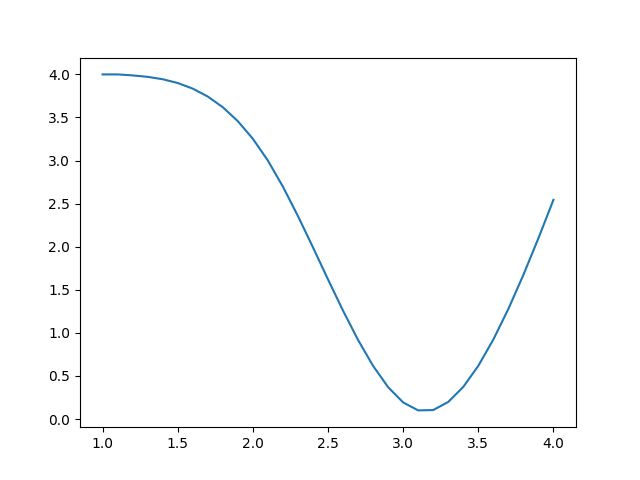

# **Clamped Cubic Spline**

As mentioned in the introduction this will be the second type of boundry condition we will discuss. There's no much difference than the natural boundry condition in this type we will impose the cubic spline to have the exact values of the first derivatives at the boundry point $a$ and $b$, Thus with just

$f'(a) = l'(x_{o}) = b_{o}$ where $f'(a)$ is the exact first derivative at $a$ and $l'(x)$ is the first derivative of the spline function at $x_{o}$, thus, if we impose $b_{o} = f'(a)$ and $b_{n} = f'(b)$ we obtain a diagonally dominant matrix too with slight difference, here it's in the form Ax = b. A, x and b respectivily.
\
\begin{bmatrix}
2(h_0+h_1) & h_1 & 0 & \dots & 0 \\
h_1 & 2(h_1+h_2) & h_2 & \dots & 0 \\
0 & h_2 & 2(h_2+h_3) & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 2(h_{n-2}+h_{n-1}) & h_{n-1} \\
0 & 0 & \dots & h_{n-1} & 2(h_{n-1})
\end{bmatrix}
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
\vdots \\
c_{n-1} \\
c_{n}
\end{bmatrix}
\begin{bmatrix}
\frac{3}{h_0}(a_1-a_0) - 3f'(a)
 \\
\frac{3}{h_1}(a_2-a_1) - 3(a_1-a_0) \\
\vdots \\
\frac{3}{h_{n-1}}(a_{n}-a_{n-1}) - \frac{3}{h_{n-2}}(a_{n-1}-a_{n-2}) \\
3(f'(b) - \frac{3}{h_{n-1}}(a_{n}-a_{n-1}))
\end{bmatrix}



with that being said the implementation is down below with it's comments explaining it clearly.


In [ ]:
def clamped(x, y, fp_a, fp_b, value): #data set x & y with the first derivatives at boundary (fp_a = f'(a)) and the value to evaluate the function at
    n = len(x)
    there = 0
    a = y[0:len(y)]
    b = [0]*n; d = [0]*n
    rhs = [0]*n
    h = [0]*(n - 1)
    for i in range(1, n):
        if(x[i] >= value and x[i - 1] <= value):
            there = i
        h[i - 1] = x[i] - x[i - 1] #filling the spacing
    matrix = [[0] * n for _ in range(n)]
    matrix[0][0] = 2*h[0]; matrix[0][1] = h[0]; matrix[n - 1][n - 1]= 2*h[n - 2]; matrix[n - 1][n - 2] = h[n - 2]
    #we are now going to fill our n*n matrix
    for i in range(1, n - 1):
        matrix[i][i - 1] = h[i - 1]       # first nonzero element in the row
        matrix[i][i] = 2*(h[i - 1] + h[i]) #the diagonal element of the row
        matrix[i][i + 1] = h[i] # the last nonzero element of the row
    rhs[0] = (3/h[0])*(a[1] - a[0]) - 3 * fp_a; rhs[n - 1] = 3 * fp_b - (3/h[n - 2])*(a[n - 1])
    #the rest is identical to the natural spline.
    for i in range(1, n - 1):
        rhs[i] = 3/h[i]*(a[i+1] - a[i]) - 3/h[i - 1]*(a[i] - a[i - 1])
    c =  solve(matrix, rhs)
    for i in range(0, n-1):
        b[i] = (1/h[i])*(y[i + 1] - y[i]) - (h[i]/3) * (c[i + 1] + 2*c[i])
        d[i] = (c[i + 1] - c[i])/(3*h[i])
    there-=1
    return a[there] + b[there] * (value - x[there]) + c[there]*(value - x[there])**2 + d[there]*(value - x[there])**3



Here is the same example for the clamped with $f'(a) = 1$ and $f'(b) = 2$


In [ ]:
print(clamped([1,2,3,4], [4,3,0.1,3],1,2 ,2.2))


2.270239980163587


Here is the plot and differece between the clamped and natural boundary conditions.

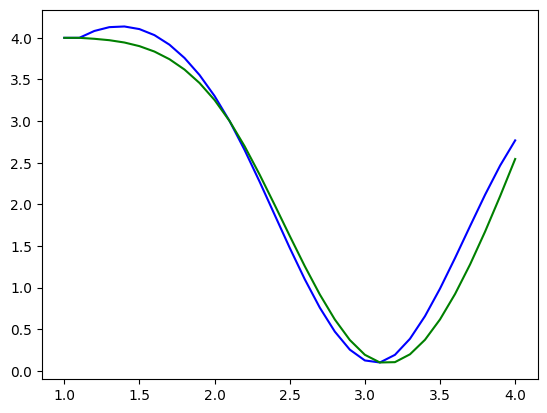

In [ ]:
#get set of points from the spline
import matplotlib.pyplot as plt
samples = [1]
yn = [4]
samples_natural = [1]
yn_natural = [4]
for i in range(1, 1000):
    if(samples[i - 1] > 4): break
    yn.append(clamped([1,2,3,4], [4,3,0.1,3],1, 2,samples[i - 1]))
    samples.append(samples[i - 1] + 0.1)
    yn_natural.append(natural_spl([1,2,3,4], [4,3,0.1, 3], samples[i - 1]))
    samples_natural.append(samples_natural[i-1] + 0.1)

plt.plot(samples, yn,'blue')
plt.plot(samples_natural, yn_natural,'green')
plt.show()

Blue plot is Clamped and green is Natural.

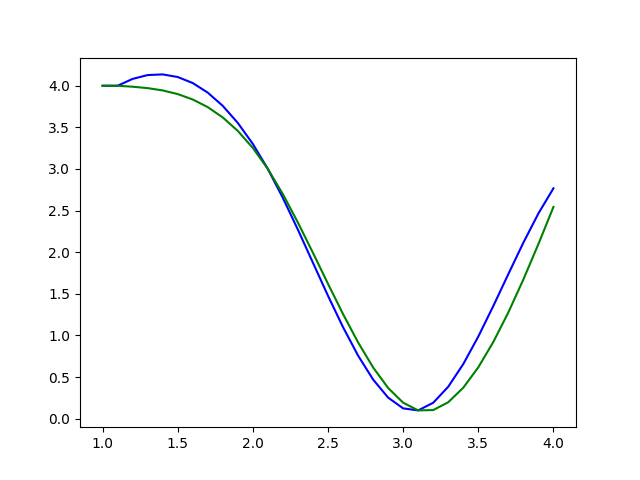